<a href="https://colab.research.google.com/github/hemant-chapa23/ActivityDetector/blob/main/DL_Assignment_2_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Libraries/Dataset

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1 Import the required libraries

In [30]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import matplotlib.pyplot as plt

## 1.2 Checking GPU

In [31]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [32]:
#@title Dataset configuration
base_path = '/content/drive/MyDrive/UCF-101'
images_path = '/content/drive/MyDrive/UCF-101/images/'
labels_path = '/content/drive/MyDrive/UCF-101-labels'
os.makedirs("/content/drive/MyDrive/UCF-101/train/", exist_ok = True)
os.makedirs("/content/drive/MyDrive/UCF-101/test/", exist_ok = True)


In [33]:
os.chdir(labels_path)

def make_train_test():
# print(os.getcwd())
  train_vdos = []
  test_vdos = []
  for category in os.listdir(labels_path):
    if "train" in category:
      train_file = open(category, 'r')
      for line in train_file:
        fields = line.split()
        vdo = fields[0]
        label = fields[1]
        # print(f"Video: {vdo}, Label: {label}")
        train_vdos.append((vdo, label))
    elif "test" in category:
      test_file = open(category, 'r')
      for vdo in test_file:
        test_vdos.append(vdo) 

  label_file = open('classInd.txt','r')
  label_list = []
  srl = []
  classname = []
  for line in label_file:
    fields = line.split()
    srl = fields[0]
    classname = fields[1]
    label_list.append((srl, classname))

  labels_df = pd.DataFrame(label_list, columns = ["label", "class"])

  training = pd.DataFrame(train_vdos, columns = ["vdo", "label"])
  testing = pd.DataFrame(test_vdos, columns = ["vdo"])

  training.drop_duplicates(keep= 'first', inplace = True)
  testing.drop_duplicates(keep = 'first', inplace = True)
  training = pd.merge(left = training, right = labels_df, how = 'inner', on = 'label')
  return training, testing


train, test = make_train_test()

# 2. Data Processing

## 2.1 Converting the data into the correct format

---

The pre-trained model requires the input in 224 X 224 X 3 tensor.

TODO:
- Mention why the framing has to be done

In [34]:
def images_from_video(video_path):
  w = 224
  h = 224
  parts = 10
  frames = []
  vr = cv2.VideoCapture(video_path)

  frame_counts = int(vr.get(cv2.CAP_PROP_FRAME_COUNT))

  #Since extracting all the frames will be processing heavy, we create intervals on the frames that will be processed
  skip = max(int(frame_counts/parts), 1)
  for part in range(0,parts,2): # This will generate 5 frames per video
    vr.set(cv2.CAP_PROP_POS_FRAMES, part * skip)
    ret, frame = vr.read()

    if not ret:
      print(ret)
      break

    frame = cv2.resize(frame, (w, h))
    frame = frame/255
    frames.append(frame)

  vr.release()
  return frames


In [35]:
"""
This will take only the video path and not the entire directory
 """
def load_videos(video_path):
  images = []
  frames_list = images_from_video(video_path)
  images.append(frames_list)
  return np.array(images)

In [37]:
""" Call to the load_videos"""
def get_frames_for_video(vdo_path):
  """
  This method accepts the number of videos to call load_vidoes for and get the frames for videos
  and returns a list of images with their frames and the training labels
  """
  # Call to load_videos
  img = load_videos(os.path.join(base_path,vdo_path)) 
  # image_list.append(img)
  training_label = train.loc[train.vdo == vdo_path,'class'].item()
  return img, training_label

## 2.2 Plot at least two samples and their captions

In [40]:
# image_list, train_label = get_frames(4)

def plot_images(image_list,train_label,video_list= [], save_or_display = 'display'):
  """
  Plotting the Images with their training labels
  Each Video will generate 5 frames and each frame is plotted
  """
  if save_or_display.lower() == 'display':
    fig, axes = plt.subplots(len(image_list), 5, figsize = (25,20))
    for (index, each_video) in enumerate(image_list):
      for (image_index, each_frame) in enumerate(each_video):
        for idx, frm in enumerate(each_frame):      
          axes[index][idx].imshow(frm, interpolation = 'nearest')
          axes[index][idx].set_title(train_label[index], fontdict={'fontsize': 15, 'fontweight': 'medium'})
  elif save_or_display.lower() == 'save':
    for (index, each_video) in enumerate(image_list):
      for (image_index, each_frame) in enumerate(each_video):
        for idx, frm in enumerate(each_frame):      
          os.chdir("/content/drive/MyDrive/UCF-101/train/")
          fig = plt.figure()
          plt.imshow(frm, interpolation = 'nearest')
          plt.savefig(f'{video_list[index]}_{index}_{idx}.jpg')
          plt.close(fig)

  return None

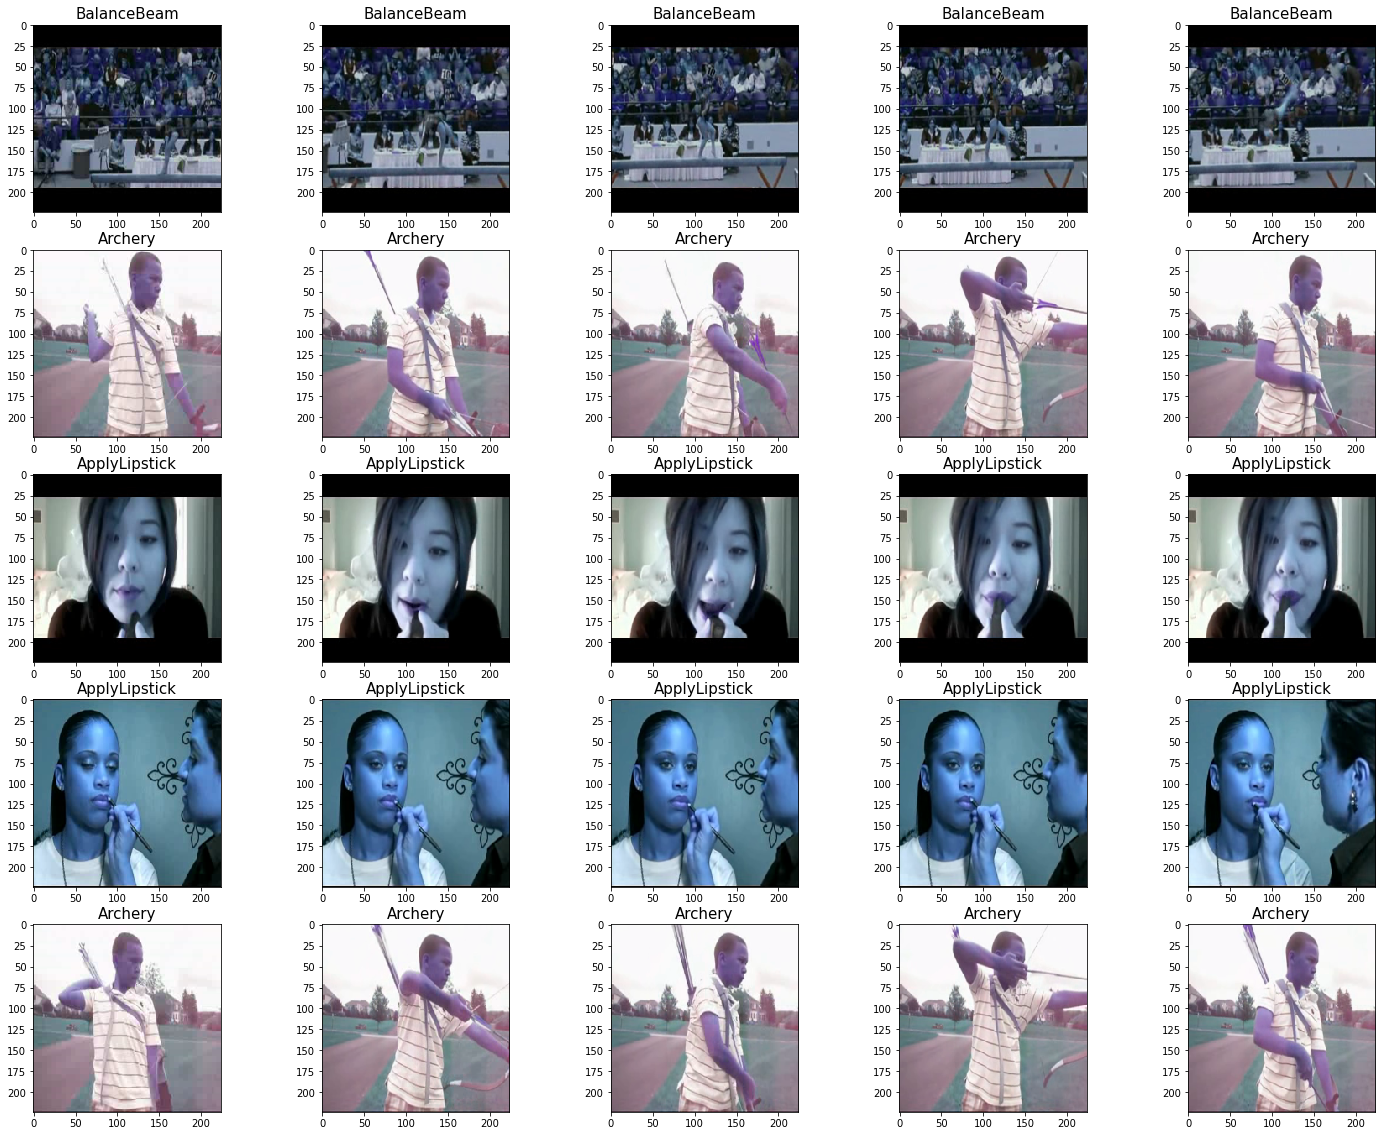

In [42]:
image_list = []
training_labels = []
vdo_list= []
for vdo in train["vdo"][np.random.randint(0,1000,5)]:
  image, label = get_frames_for_video(vdo)
  image_list.append(image)
  training_labels.append(label)
  vdo_list.append(vdo.split("/")[1].split(".")[0])
plot_images(image_list, training_labels, vdo_list, save_or_display = 'save') # Saved in train folder
plot_images(image_list, training_labels, vdo_list, save_or_display = 'display') # display interactively

In [36]:
# path=[]
# for label in labels:
#     path.append(images_path + label +"/")
# path[0]

In [29]:
# # image_list, train_label = get_frames(4)

# def plot_images(image_list,train_label, save = False):
#   """
#   Plotting the Images with their training labels
#   Each Video will generate 5 frames and each frame is plotted
#   """
#   fig, axes = plt.subplots(len(image_list), 5, figsize = (25,20))
#   for (index, each_video) in enumerate(image_list):
#     for (image_index, each_frame) in enumerate(each_video):
#       for idx, frm in enumerate(each_frame):
#         axes[index][idx].imshow(frm, interpolation = 'nearest')
#         axes[index][idx].set_title(train_label[index], fontdict={'fontsize': 15, 'fontweight': 'medium'})
#   return None


In [38]:
# """
# Plotting images and the lables from training videos
# """
# image_list = []
# training_labels = []
# for vdo in train["vdo"][np.random.randint(0,1000,5)]:
#   image, label = get_frames_for_video(vdo)
#   image_list.append(image)
#   training_labels.append(label)
# plot_images(image_list, training_labels)


'\nPlotting images and the lables from training videos\n'

In [135]:
# """ Call to the load_videos"""
# def get_frames(num_videos = 5):
#   """
#   This method accepts the number of videos to call load_vidoes for and get the frames for videos
#   and returns a list of images with their frames and the training labels
#   """
#   image_list = []
#   training_label = []
#   for vdo in train["vdo"][np.random.randint(0,1000,num_videos)]: # Any random 5 videos
#     # Call to load_videos
#     img = load_videos(os.path.join(base_path,vdo)) 
#     image_list.append(img)
#     training_label.append(train.loc[train.vdo == vdo,'class'].item())
#   return image_list, training_label

In [ ]:
"""
Populate  Images from Train and test Videos in different folders
"""
for vdo in train["vdo"]:
  print(vdo)

In [130]:

# def load_videos(data_dir):
#   label_index = 0
#   labels = []
#   images = []

#   for folder in data_dir:
#     # print("folder: ", folder )
#     for video in tqdm(os.listdir(folder)):
      
#       video_path = os.path.join(folder, video)
#       # print("video_path:", video_path)
#       frames_list = images_from_video(video_path)
#       print(f"Video: {video}, Frames: {len(frames_list)}")
#       images.append(frames_list)
#       labels.append(label_index)
#     label_index += 1

#   return np.array(images), np.array(labels, dtype = 'int8')


In [ ]:
# images, labels = load_videos(videos_path[1:2])

In [144]:
# load_videos(os.path.join(base_path,"ApplyLipstick/v_ApplyLipstick_g02_c02.avi"))

In [145]:
# labels = []
# videos_path = []
# for label in os.listdir(base_path):
#   labels.append(label)
#   videos_path.append(base_path+'/'+label+'/')
# labels.sort()
# videos_path.sort()

In [146]:
# rec = cv2.VideoCapture("/content/drive/MyDrive/UCF-101/ApplyLipstick/v_ApplyLipstick_g02_c02.avi")

In [147]:
# rec.get(cv2.CAP_PROP_FRAME_COUNT)

In [148]:
# rec.set(cv2.CAP_PROP_POS_FRAMES, 8 * 10)

In [149]:
# rec.read()[0]

In [150]:
# pix = cv2.resize(rec.read()[1], (240,240))

In [151]:
# from matplotlib import pyplot as plt
# plt.imshow(pix, interpolation='nearest')
# plt.show()
